# Heat equation - Retrieving operator by analytical formulation

In [28]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint_adjoint as odeint

Graphic tools

In [2]:
def simple_plotter(ks, title='Simple plot'):
    """
    Graphic tool to plot simple values
    """
    fig, ax = plt.subplots()
    fig.tight_layout()
    plt.title(title)
    for k in ks:
        ax.plot(range(len(k)), k)
    
    plt.show()

In [3]:
def show_state(a, title):
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im);
    plt.xlabel('x');
    plt.ylabel('t');
    plt.title(title)

## Analytical solution

Compute the analytical solution u(t, x)

In [4]:
def analytical_heat_1d(t, x, n_max: int=1, rand=False):
    """
    Analytical solution to 1D heat equation.
    Return solution for a tuple (t, x)
    """
    L = 1.
    
    cn = np.ones(n_max)
    if rand:
        cn = np.random.rand(n_max)
    
    u = np.sum([cn[n] * np.exp((-np.pi**2 * n**2 * t) / L) * np.sin((n * np.pi * x) / L) for n in range(n_max)], axis=0)
    return u, cn

In [5]:
def get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand=False):
    """
    Compute heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_heat_1d(t_axis[:, None], x_axis[None, :], 50, rand)

Compute the analytical derivative by time of the solution u(t,x)

In [6]:
def analytical_grad_t_heat_1d_t(t, x, cn=None, n_max=1):
    """
    Analytical gradient by t of the solution to 1D heat equation
    Return value for a tuple (t, x)
    """
    
    if cn is None:
        cn = np.ones(n_max)
        
    return np.sum([-np.pi**2 * n**2 * np.exp(-np.pi**2 * n**2 * t) * np.sin(n * np.pi * x) for n in range(n_max)], axis=0)

In [7]:
def get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn=None):
    """
    Compute gradient by t to heat equation solution values for a set of (t, x) tuples.
    """
    t_axis = np.linspace(t_min, t_max, t_n)
    x_axis = np.linspace(x_min, x_max, x_n)
    
    return analytical_grad_t_heat_1d_t(t_axis[:, None], x_axis[None, :], cn, 10)

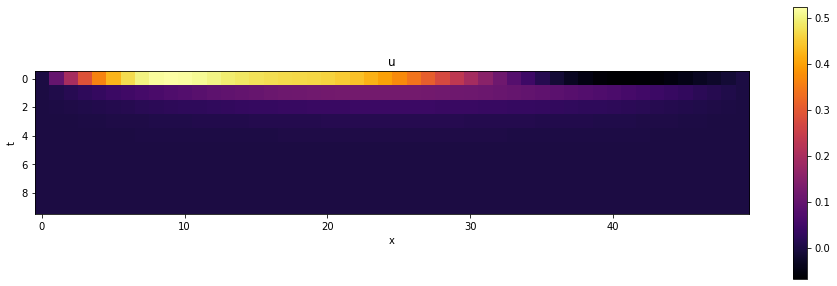

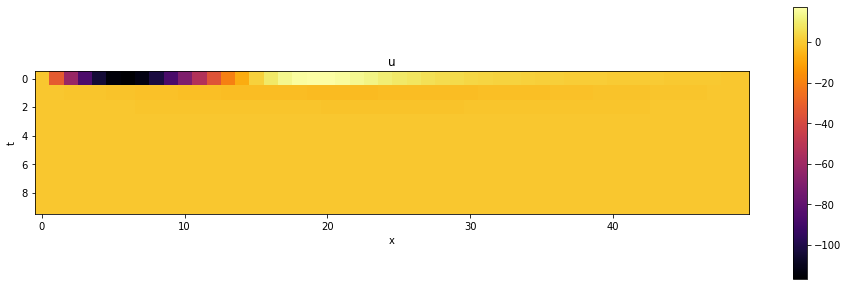

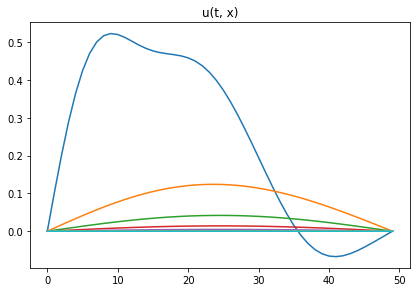

In [10]:
u_true, cn = get_heat(1., 0.01, 1., 0., 10, 50, True)
g_u_true = get_heat_grad_t(1., 0.01, 1., 0., 10, 50, cn)

show_state(u_true, 'u')
show_state(g_u_true, 'u')
simple_plotter(u_true, 'u(t, x)')

---

## Get operator F

Choice of parameters for the computations.

Small function to visualize the vector field expected for operator F.

In [73]:
t_n = 50
x_n = 50
t_max, t_min = 0.2, 0.01
x_max, x_min = 1.0, 0.01

Considering the linear relation $Ax = b$, we can determine the operator F by setting $A = U$, $x = F$ and $b = U_t$. Thus, let's set:
$A x = b$

$U F = U_{t}$

$U^{T} F^{T} = U_{t}^{T}$

$U U^{T} F^{T} = U U_{t}^{T}$

$F^{T} = (U U^{T})^{-1} U U_{t}^{T}$

In [74]:
def get_F(u, g_u):
    tmp = np.matmul(u, u.T)
    tmp2 = np.linalg.pinv(tmp)
    tmp3 = np.matmul(u, g_u.T)
    Ft = np.matmul(tmp2, tmp3)
    return Ft.T

In [75]:
def get_ode_F(u, g_u):
    N = len(u)
    F = np.linalg.solve(u @ u.T + 1e-8 * np.eye(N), u @ g_u.T).T
    return F

#### Analyze u obtains from operator F

In [76]:
def analyze_error(F, u, g_u):
    return np.mean(np.abs(F @ u - g_u))

In [77]:
def forward_euler(F, u, dt):
    return u + dt * F @ u

def solve(F, u0, t, dt=0.1, func=forward_euler):
    K = int(t / dt)
    u = np.copy(u0)

    for i in range(K):
        u = func(F, u, dt)
    return u

(50, 50)
(50, 50)
Error with F :  0.008324938140592849
Error with F2 :  0.07627737888095319


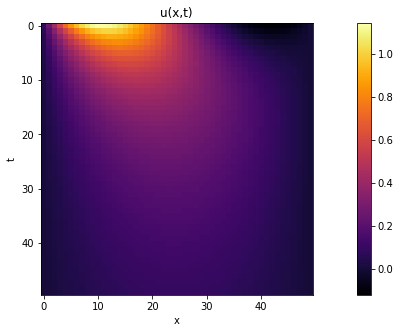

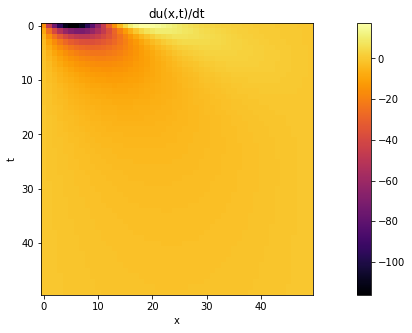

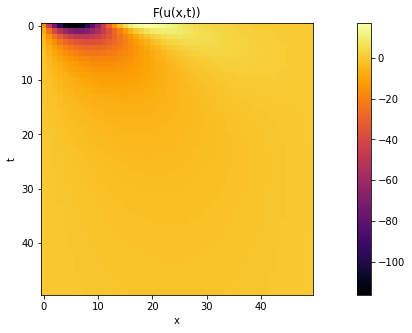

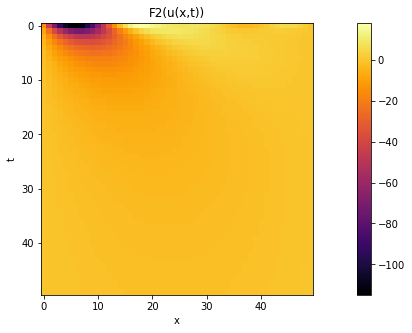

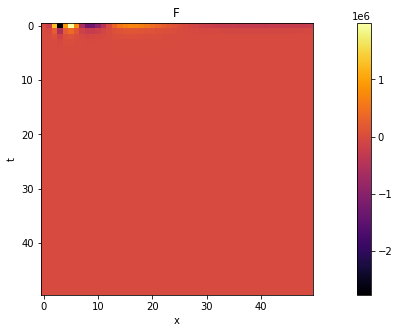

In [85]:
u, cn = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, True)
g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn)

F = get_F(u, g_u)
F2 = get_ode_F(u, g_u)
print(F.shape)
print(F2.shape)

print("Error with F : ", analyze_error(F, u, g_u))
print("Error with F2 : ", analyze_error(F2, u, g_u))

test = solve(F2, u[0,:], t_max)
show_state(u, 'u(x,t)')
show_state(g_u, 'du(x,t)/dt')
show_state(F @ u, 'F(u(x,t))')
show_state(F2 @ u, 'F2(u(x,t))')
show_state(F, 'F')
# print(u[0, :].shape)

Let's now introduction a simple Tikhonov regularization term. Our operator should now be computed as:

$F = U_{t} U^{T} (U U^{T} + \Gamma \Gamma^{T})^{-1}$

In [20]:
def get_F_with_Tikhonov(u, g_u):
#     u = get_heat(t_max, t_min, x_max, x_min, t_n, x_n)[1:]
#     g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n)[1:]
    
    t_n = u.shape[0]
    tmp = np.matmul(g_u, u.T)
    tmp2 = np.matmul(u, u.T)
    tmp3 = np.matmul(np.identity(t_n), np.identity(t_n).T) # regularization
    tmp4 = np.linalg.pinv(tmp2 + tmp3)
    F = np.matmul(tmp, tmp4)
    return F

0.913129761099351


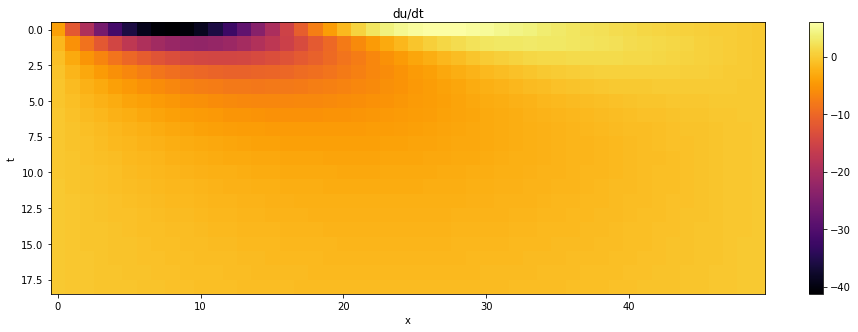

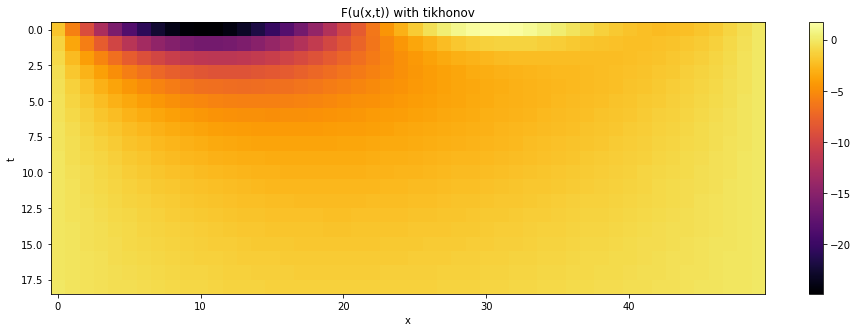

In [21]:
u, cn = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, True)
g_u = get_heat_grad_t(t_max, t_min, x_max, x_min, t_n, x_n, cn)
F_tik = get_F_with_Tikhonov(u[1:], g_u[1:])

show_state(g_u[1:], 'du/dt')
show_state(F_tik @ u[1:], 'F(u(x,t)) with tikhonov')
print(analyze_error(F_tik, u[1:], g_u[1:]))

There's no need to use a regularization in this simple case. It makes thing worse actually.